# Dependency

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras tools
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from keras.callbacks import ModelCheckpoint

!nvidia-smi

Sun Jun  2 16:32:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 474.64       Driver Version: 474.64       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:09:00.0 N/A |                  N/A |
| 40%    0C    P8    N/A /  N/A |    621MiB /  2048MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load data

In [96]:
data = pd.read_csv("dataset/merged_cleaned_data.csv")
data.columns

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctsomecol18_24',
       'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over',
       'pctemployed16_over', 'pctunemployed16_over', 'pctprivatecoverage',
       'pctprivatecoveragealone', 'pctempprivcoverage', 'pctpubliccoverage',
       'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian',
       'pctotherrace', 'pctmarriedhouseholds', 'birthrate', 'statefips',
       'countyfips', 'avghouseholdsize', 'mean_private_coverage',
       'expected_private_coverage'],
      dtype='object')

### Create features

Normalize the death_rate, target_death_rate and diagnosis_rate

In [97]:
data['death_rate_per_1000'] = data['avgdeathsperyear'] / data['popest2015'] * 1000
data['target_death_rate_per_1000'] = data['target_deathrate'] / data['popest2015'] * 1000
data['diagnosis_rate_per_1000'] = data['avganncount'] / data['popest2015'] * 1000
data['diagnosis_rate_against_incidence'] = data['avganncount'] / data['incidencerate']

data['distance_from_target'] = data['target_death_rate_per_1000'] - data['death_rate_per_1000'] 
data['mortality_from_diag'] = data['avgdeathsperyear']/ data['avganncount'] 

data['insurance_gap'] = data['pctprivatecoverage'] - data['pctpubliccoverage']

In [98]:
data.drop(['avgdeathsperyear', 'popest2015', 'target_deathrate', 'avganncount', 'mean_private_coverage',
       'expected_private_coverage'], axis=1, inplace=True)

In [99]:
# List of features to exclude to prevent data leakage
features_to_exclude = [
    'death_rate_per_1000', 
    'target_death_rate_per_1000',  # Directly related to target
    'distance_from_target',        # Derived from target
    'mortality_from_diag'          # Directly measures outcome similar to target
]

features = [
    'pctunemployed16_over',  # Existing feature
    'pctpubliccoverage',     # Existing feature
    'pctprivatecoverage',    # Existing feature
    'medincome',             # Existing feature
    'povertypercent',        # Existing feature
    'medianagefemale',       # Highly correlated
    'medianagemale',         # Highly correlated
    'avghouseholdsize',      # Highly correlated
    'pcths25_over',          # Highly correlated
    'pctbachdeg25_over',     # Highly correlated
    'pctempprivcoverage',    # Highly correlated
    'insurance_gap',         # Derived feature showing difference in coverages
    'pctprivatecoveragealone',  # Highly correlated
    'pctemployed16_over',    # Moderately correlated
    'pctpubliccoveragealone' # Coverage feature
    # Consider adding or removing features based on model performance and domain knowledge
]


# Build model predict mortality_from_diag

In [111]:
X = data[features]
predict_features = 'death_rate_per_1000'
y = data[predict_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
X_train.shape

(2132, 15)

In [115]:
nn = Sequential()
nn.add(Input(shape=(15,)))
nn.add(Dense(64, kernel_initializer='normal',activation='relu'))
nn.add(Dense(128, kernel_initializer='normal',activation='relu'))
nn.add(Dense(128, kernel_initializer='normal',activation='relu'))
nn.add(Dense(128, kernel_initializer='normal',activation='relu'))
nn.add(Dropout(rate=0.2))
nn.add(Dense(1, activation="linear"))

# Compile the model
nn.compile(optimizer="adam", loss='mae', metrics=["mse"])

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = ModelCheckpoint("models/" + predict_features + "/" + checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

# Train the model
history = nn.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
27/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9226 - mse: 4.3303 
Epoch 1: val_loss improved from inf to 0.38022, saving model to models/death_rate_per_1000/Weights-001--0.38022.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5238 - mse: 3.1784 - val_loss: 0.3802 - val_mse: 0.2758
Epoch 2/50
39/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3962 - mse: 0.2669 
Epoch 2: val_loss improved from 0.38022 to 0.25523, saving model to models/death_rate_per_1000/Weights-002--0.25523.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3840 - mse: 0.2527 - val_loss: 0.2552 - val_mse: 0.1243
Epoch 3/50
34/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2887 - mse: 0.1479 
Epoch 3: val_loss did not improve from 0.25523
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2935 - mse: 0.1526 - val_loss: 0.2555 - val_mse: 0.1166
Epoch 4/50
43/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2814 - mse: 0.1463 
Epoch 4: val_loss improved from 0.25523 to 0.23197, saving model to models/dea

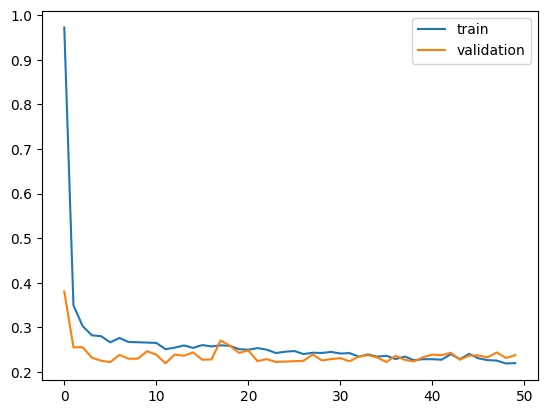

In [125]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig(f"plot/{predict_features}_training_history.png")
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error: 0.09746849461786856
Mean Absolute Error: 0.22173910935825353
R2 Score: 0.7400086914115447


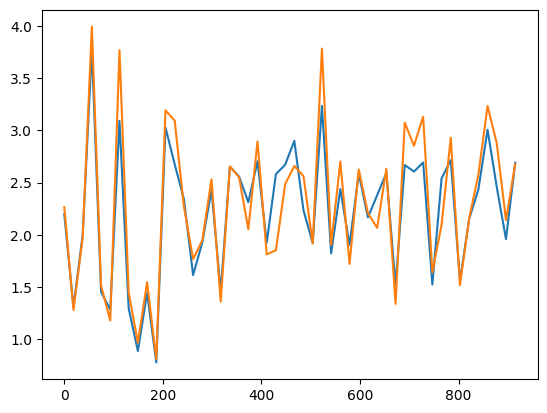

In [123]:
# load the best weight
nn.load_weights("models\death_rate_per_1000\Weights-016--0.21884.keras")

# evaluate the model
y_pred = nn.predict(X_test)
y_pred = y_pred.reshape(-1)

# calculate the accuracy
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Plot the results
sample = np.linspace(0, len(y_test), 50)
plt.plot(sample, y_pred[:50])
plt.plot(sample, y_test[:50])
plt.savefig(f"plot/{predict_features}_{mae}_{mse}_{r2}.png")
plt.show()